## 基于hugging face框架训练FashionMINST分类识别

In [44]:
from datasets import load_dataset
from utils.img_utils import *
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer, \
    DefaultDataCollator, pipeline
import evaluate

from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

mirror = 'tuna'


In [45]:

dataset = load_dataset('fashion_mnist', split='train[:5000]')

dataset = dataset.train_test_split(test_size=0.2)

print(dataset)

Found cached dataset fashion_mnist (C:/Users/82716/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)
Loading cached split indices for dataset at C:\Users\82716\.cache\huggingface\datasets\fashion_mnist\fashion_mnist\1.0.0\8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1\cache-24d2e844aeff9aeb.arrow and C:\Users\82716\.cache\huggingface\datasets\fashion_mnist\fashion_mnist\1.0.0\8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1\cache-2c267f8f40b07553.arrow


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})


Dataset({
    features: ['image', 'label'],
    num_rows: 4000
})
{'image': Image(decode=True, id=None), 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}
{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x28BCBE6EF40>, 'label': 9}


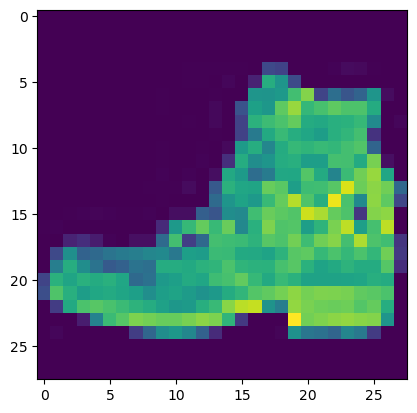

{'T - shirt / top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9} {0: 'T - shirt / top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


In [46]:
print(dataset['train'])
print(dataset['train'].features)
print(dataset['train'][0])
show_img(dataset['train'][0]['image'])

labels = dataset["train"].features["label"].names
id2label = dict(enumerate(labels))
label2id = {v: k for k, v in id2label.items()}
print(label2id, id2label)

In [47]:
checkpoint = 'google/vit-base-patch16-224-in21k'
image_processor = AutoImageProcessor.from_pretrained(checkpoint)
print(image_processor)

size = (
    image_processor.size['shortest_edge']
    if 'shortest_edge' in image_processor.size
    else (image_processor.size['height'], image_processor.size['width'])
)
print(size)

_transforms = Compose([
    RandomResizedCrop(size),
    ToTensor(),
    Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])


def transforms(examples):
    examples['pixel_values'] = [_transforms(img.convert('RGB')) for img in examples['image']]
    del examples['image']
    return examples


dataset = dataset.with_transform(transforms)
print(dataset)
# 只有获取元素时才转换
print(dataset['train'][0].keys())
print(dataset['train'][0]['pixel_values'].shape)


ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

(224, 224)
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})
dict_keys(['label', 'pixel_values'])
torch.Size([3, 224, 224])


In [48]:

accuracy = evaluate.load('accuracy')


def compute_metrics(eval_pred):
    global accuracy
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)


In [49]:

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

print(model)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [50]:
training_args = TrainingArguments(
    output_dir='../logs/fashion',
    remove_unused_columns=False,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=5e-5,
    fp16=True,
    auto_find_batch_size=True,
    # per_device_train_batch_size=16,
    # gradient_accumulation_steps=4,
    # per_device_eval_batch_size=16,
    gradient_checkpointing=True,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',

    dataloader_num_workers=6
)

print(training_args)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=DefaultDataCollator(),
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)


TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=True,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=True,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=True,
greater_is_better=True,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore

Epoch,Training Loss,Validation Loss


TrainOutput(global_step=1500, training_loss=0.8210333277384441, metrics={'train_runtime': 263.9559, 'train_samples_per_second': 45.462, 'train_steps_per_second': 5.683, 'total_flos': 9.29970550849536e+17, 'train_loss': 0.8210333277384441, 'epoch': 3.0})

In [51]:

trainer.train()


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=1500, training_loss=0.5497718607584635, metrics={'train_runtime': 266.2948, 'train_samples_per_second': 45.063, 'train_steps_per_second': 5.633, 'total_flos': 9.29970550849536e+17, 'train_loss': 0.5497718607584635, 'epoch': 3.0})

Found cached dataset fashion_mnist (C:/Users/82716/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


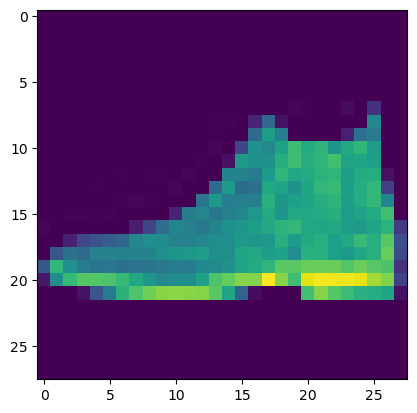

[{'score': 0.9016076326370239, 'label': 'Ankle boot'},
 {'score': 0.023818131536245346, 'label': 'Sneaker'},
 {'score': 0.012388459406793118, 'label': 'Sandal'},
 {'score': 0.010368343442678452, 'label': 'Trouser'},
 {'score': 0.009399482980370522, 'label': 'T - shirt / top'}]

In [52]:
ds = load_dataset("fashion_mnist", split="test[:10]")
image = ds['image'][0]
show_img(image)

classifier = pipeline(
    'image-classification',
    model=model.to('cpu'),
    image_processor=image_processor
)

classifier(image)